# SIR model for COVID-19 reproducing the paper from Ma, 2022

In [1]:
import numpy as np
import matplotlib as plt
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
%matplotlib widget
%config InlineBackend.figure_format='retina'

### Classic SIR model

\begin{align*} \frac{{dS\left(t \right)}}{{dt}} &= - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} \tag{1}\\ \frac{{dI\left(t \right)}}{{dt}} &= \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \lambda I\left(t \right) \tag{2}\\ \frac{{dR\left(t \right)}}{{dt}} &= \lambda I\left(t \right) \tag{3} \end{align*}

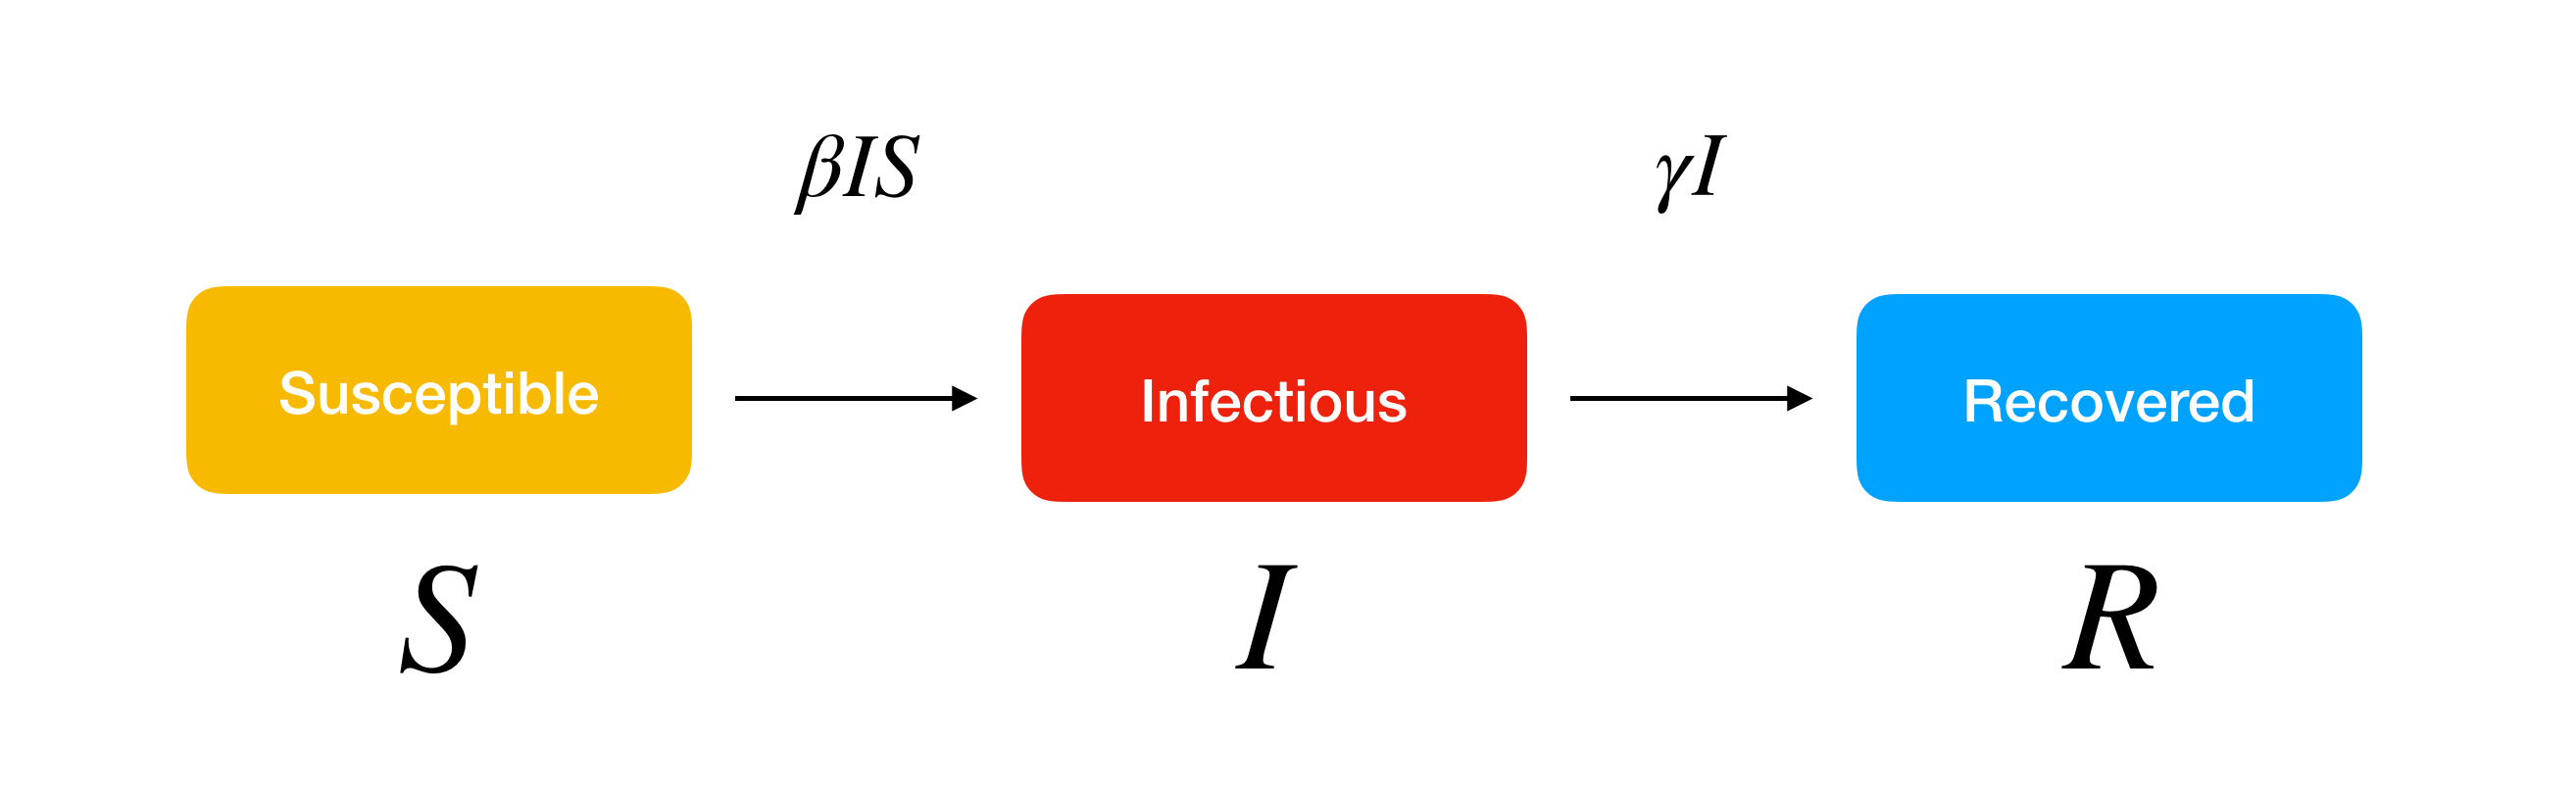

### Extended SEIR model

\begin{align*} \frac{{dS\left(t \right)}}{{dt}} &= - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \alpha S\left(t \right) \tag{4}\\ \frac{{dE\left(t \right)}}{{dt}} &= \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \gamma E\left(t \right) \tag{5}\\ \frac{{dI\left(t \right)}}{{dt}} &= \gamma E\left(t \right) - \delta I\left(t \right) \tag{6}\\ \frac{{dQ\left(t \right)}}{{dt}} &= \delta I\left(t \right) - \lambda Q\left(t \right) - \kappa Q\left(t \right) \tag{7}\\ \frac{{dR\left(t \right)}}{{dt}} &= \lambda Q\left(t \right) \tag{8}\\ \frac{{dD\left(t \right)}}{{dt}} &= \kappa Q\left(t \right) \tag{9}\\ \frac{{dP\left(t \right)}}{{dt}} &= \alpha S\left(t \right) \tag{10} \end{align*}

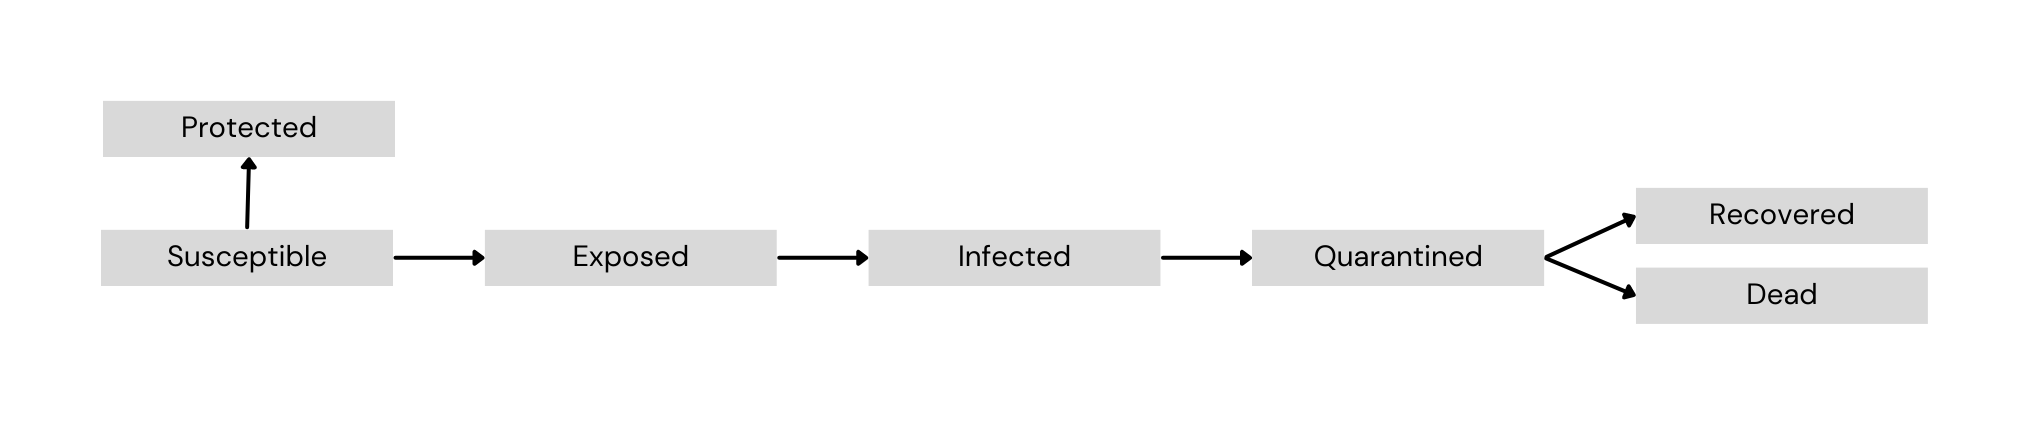

### States of the SEIR model

- $S$: susceptible people
- $E$: exposed people
- $I$: infected people not quarantined
- $Q$: infected people quarantined
- $R$: recovered people
- $D$: dead people
- $P$: protected people

### Parameters of the SEIR model
- $N$: total number of people
- $\alpha$: protection rate
- $\beta$: infectious rate
- $\gamma^{-1}$: average incubation time
- $\delta^{-1}$: average quarantine time
- $\lambda$: cure rate
- $\kappa$: mortality rate

The `local_SEIR.py` file contains two functions, one is `solveSEIR` which is intended for using in a notebook and experiment with different inputs and outputs manually, the other is `solveSEIR_UQpy` which is intended for `UQpy` as in only returns the infected number as output.

In [3]:
from local_SEIR import solveSEIR

Set initial parameters with values from the paper.

In [4]:
alpha = 0.0185  # protection rate
beta = 0.7      # infectious rate
gamma_inv = 5   # average incubation time
delta_inv = 7   # average quarantine time
lam = 0.1       # cure rate
kappa = 0.001   # mortality rate

Call the `solveSEIR` function to produce the solution.

In [5]:
sol = solveSEIR(
    input_parameters=[alpha, beta, gamma_inv, delta_inv, lam, kappa])

Plot the results across time, and specify starting and ending day as in the paper.

In [6]:
t = np.linspace(0, 180, 10000)

start_day = 5
end_day = 180
timespan = (t >= start_day) & (t <= end_day)

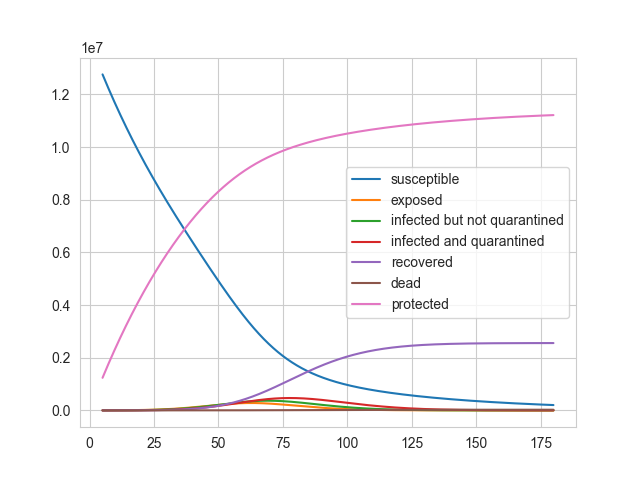

In [6]:
fig, ax = plt.subplots()
ax.plot(t[timespan], sol[0, timespan], label="susceptible")
ax.plot(t[timespan], sol[1, timespan], label="exposed")
ax.plot(t[timespan], sol[2, timespan], label="infected but not quarantined")
ax.plot(t[timespan], sol[3, timespan], label="infected and quarantined")
ax.plot(t[timespan], sol[4, timespan], label="recovered")
ax.plot(t[timespan], sol[5, timespan], label="dead")
ax.plot(t[timespan], sol[6, timespan], label="protected")
ax.legend()
plt.show()

### Basic reproduction number

The basic reproduction number is defined as

\begin{equation*} R0\ = \ \left({1 + \frac{{\ln (I(t)/t)}}{\gamma }} \right)\left({1 + \frac{{\ln (I(t)/t)}}{\lambda }} \right) \tag{11} \end{equation*}

where $I(t)$ is the number of infected populations by time $t$.

We define a function to compute it.

In [7]:
def calculate_R0(Y, t, gamma, lam):
    return (1 + np.log(Y/t)/gamma) * (1 + np.log(Y/t)/lam)

### Sensitivity Analysis

Import relevant modules and classes from `UQpy`.

In [8]:
from UQpy.run_model.RunModel import RunModel
from UQpy.run_model.model_execution.PythonModel import PythonModel
from UQpy.distributions import Uniform
from UQpy.distributions.collection.JointIndependent import JointIndependent
from UQpy.sensitivity.SobolSensitivity import SobolSensitivity
from UQpy.sensitivity.PostProcess import *

Create `PythonModel` object.

In [9]:
model = PythonModel(
    model_script="local_SEIR.py", # this file must be in the same folder
    model_object_name="solveSEIR_UQpy", # this is the name of the main function called in local_SEIR.py
    var_names=["alpha", # same order used when unpacking the parameters in solveSEIR
               "beta",
               "gamma_inv",
               "delta_inv",
               "lam",
               "kappa"],
    delete_files=True
)

runmodel_obj = RunModel(model=model)

We set a uniform distribution as in the paper using `UQpy.distributions.Uniform`.

The `Uniform` distribution is based on `scipy` and receives `loc` and `scale`, so if
$$
U\sim U([a,b]) \qquad f_U(x;a,b) = \frac{1}{b-a}
$$
then
$$
a = loc \qquad b = loc + scale
$$
therefore
$$
loc = a \qquad scale = b - a
$$

In [10]:
A     = Uniform(0.085, (0.183 - 0.085 ))
B     = Uniform(0.7, (0.9 - 0.7))
G_inv = Uniform(5, (7 - 5 ))
D_inv = Uniform(7, (14 - 7))
L     = Uniform(0.1, (0.5 - 0.1 ))
K     = Uniform(0.001, (0.05 - 0.001 ))

dist_object = JointIndependent([A, B, G_inv, D_inv, L, K])

Perform the sensitivity analysis and measure the time taken by the cell to execute it.

In [11]:
%%time
SA = SobolSensitivity(runmodel_obj, dist_object)
SA.run(n_samples=5000, estimate_second_order=True)

CPU times: user 2min 34s, sys: 10.1 s, total: 2min 45s
Wall time: 2min 49s


Investigate the shape of the resulting quantities.

In [12]:
np.shape(SA.first_order_indices)

(6, 10000)

In [13]:
np.shape(SA.second_order_indices)

(15, 10000)

Plot the first order indexes in 3D.

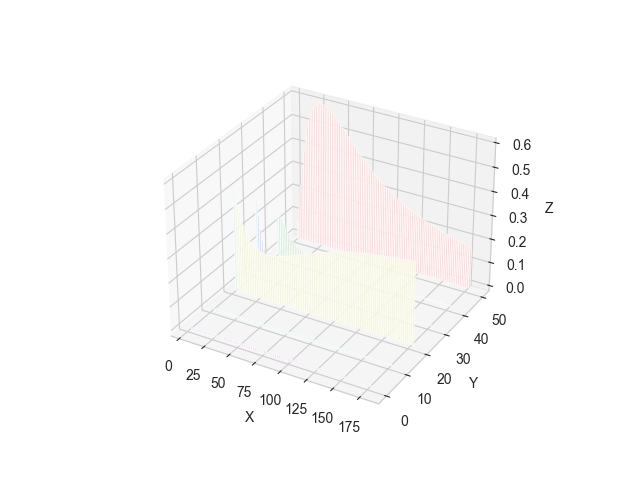

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

c = ['r', 'g', 'b', 'y', 'c', 'm']
z = [50, 40, 30, 20, 10, 0]

for i in range(np.shape(SA.first_order_indices.T[1:])[1]):
    xs = t[timespan]
    ys = SA.first_order_indices[i, timespan]
    
    xs = xs[::100]
    ys = ys[::100]

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c[i]] * len(xs)
    cs[0] = 'c'
    ax.bar(xs, ys, zs=z[i], zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### Plotting first order Sobol indices in time

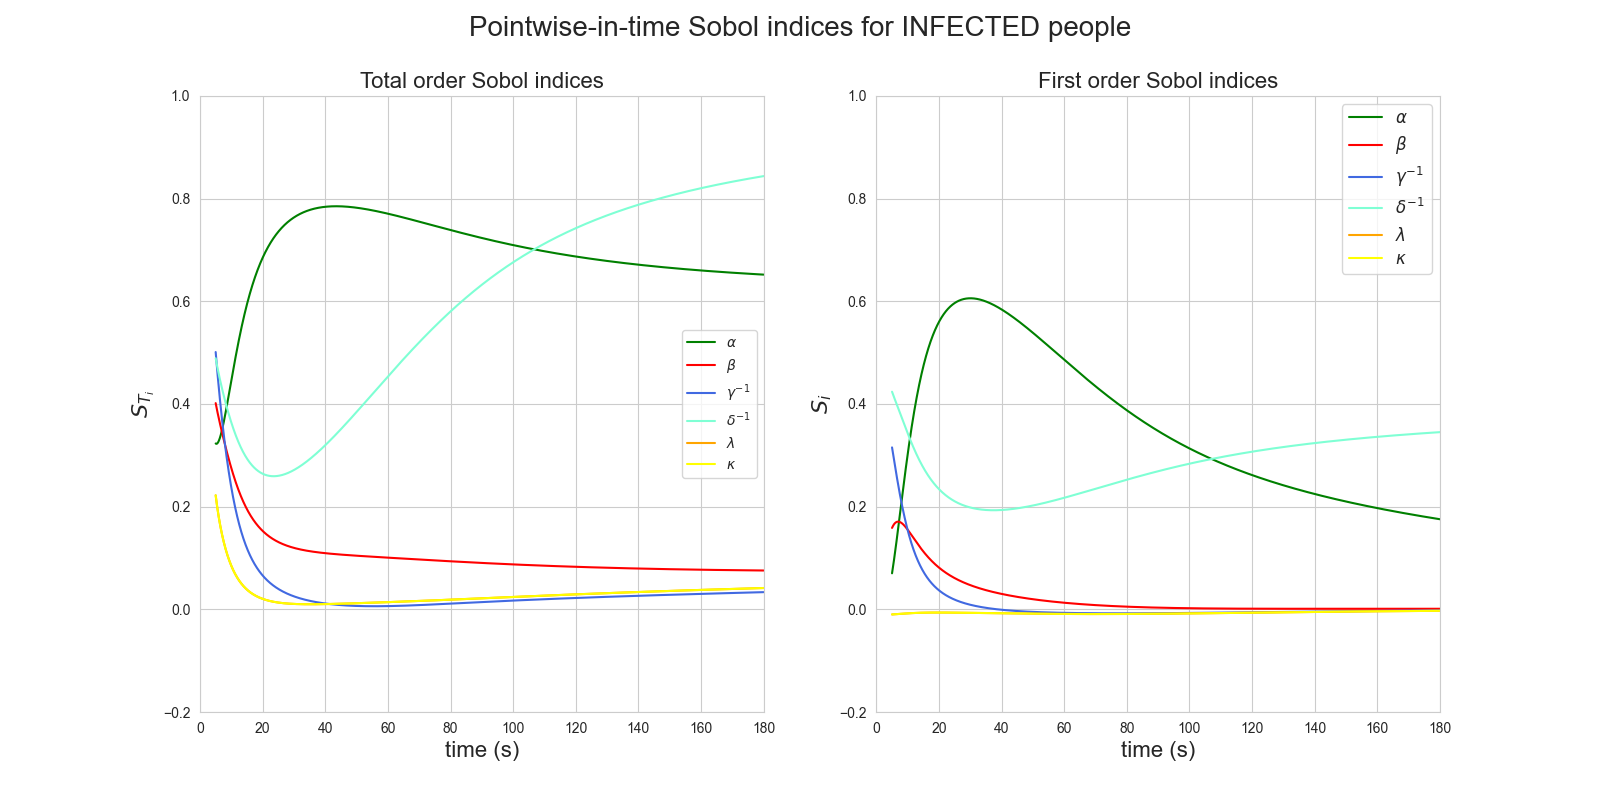

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].plot(t[timespan], SA.total_order_indices[0, timespan], "g",label=r"$\alpha$")
ax[0].plot(t[timespan], SA.total_order_indices[1, timespan], "r" ,label=r"$\beta$")
ax[0].plot(t[timespan], SA.total_order_indices[2, timespan], label=r"$\gamma^{-1}$", color="royalblue")
ax[0].plot(t[timespan], SA.total_order_indices[3, timespan], label=r"$\delta^{-1}$", color="aquamarine")
ax[0].plot(t[timespan], SA.total_order_indices[4, timespan], label=r"$\lambda$", color="orange")
ax[0].plot(t[timespan], SA.total_order_indices[5, timespan], label=r"$\kappa$", color="yellow")

ax[0].set_title("Total order Sobol indices", fontsize=16)
ax[0].set_xlabel("time (s)", fontsize=16)
ax[0].set_ylabel(r"$S_{T_i}$", fontsize=16)
ax[0].set_xbound(0, t[-1])
ax[0].set_ybound(-0.2, 1)
ax[0].legend()

ax[1].plot(t[timespan], SA.first_order_indices[0, timespan], "g",label=r"$\alpha$")
ax[1].plot(t[timespan], SA.first_order_indices[1, timespan], "r" ,label=r"$\beta$")
ax[1].plot(t[timespan], SA.first_order_indices[2, timespan], label=r"$\gamma^{-1}$", color="royalblue")
ax[1].plot(t[timespan], SA.first_order_indices[3, timespan], label=r"$\delta^{-1}$", color="aquamarine")
ax[1].plot(t[timespan], SA.first_order_indices[4, timespan], label=r"$\lambda$", color="orange")
ax[1].plot(t[timespan], SA.first_order_indices[5, timespan], label=r"$\kappa$", color="yellow")

ax[1].set_title("First order Sobol indices", fontsize=16)
ax[1].set_xlabel("time (s)", fontsize=16)
ax[1].set_ylabel(r"$S_i$", fontsize=16)
ax[1].set_xbound(0, t[-1])
ax[1].set_ybound(-0.2, 1)
ax[1].legend(fontsize=12)


##The order is still not clear
#ax[2].plot(T, SA.second_order_indices[0, :], "r" ,label=r"$beta$")
#ax[2].plot(T, SA.second_order_indices[1, :], "g",label=r"$alpha$")
#ax[2].plot(T, SA.second_order_indices[2, :], label=r"$gamma$", color="royalblue")
#ax[2].plot(T, SA.second_order_indices[3, :], label=r"$delta$", color="aquamarine")
#ax[2].plot(T, SA.second_order_indices[4, :], label=r"$kappa$", color="yellow")
#ax[2].plot(T, SA.second_order_indices[5, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[6, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[7, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[8, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[9, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[10, :], label=r"$lambda$", color="orange")
#
#
#ax[2].set_title("Second order Sobol indices", fontsize=16)
#ax[2].set_xlabel("time (s)", fontsize=16)
#ax[2].set_ylabel(r"$S_i$", fontsize=16)
#ax[2].set_xbound(0, t_f)
#ax[2].set_ybound(-0.5, 1.2)
#ax[2].legend(fontsize=12)
#
fig.suptitle("Pointwise-in-time Sobol indices for INFECTED people", fontsize=20)

plt.show()

In [26]:
#Creating a vector of indices where all elements with value <0 become 0
sobol_first=SA.first_order_indices[:, timespan]

from scipy.integrate import cumulative_trapezoid

sobol_first[sobol_first<0]=0

x = t[timespan]

first_s_int=np.zeros(6)

for i in range(6):
    y=sobol_first[i,:]
    result = cumulative_trapezoid(y, x)
    first_s_int[i]=sum(result)

In [28]:
first_s_int

array([361139.76357742,  31473.64868936,  20418.0899816 , 218105.22026924,
            0.        ,      0.        ])

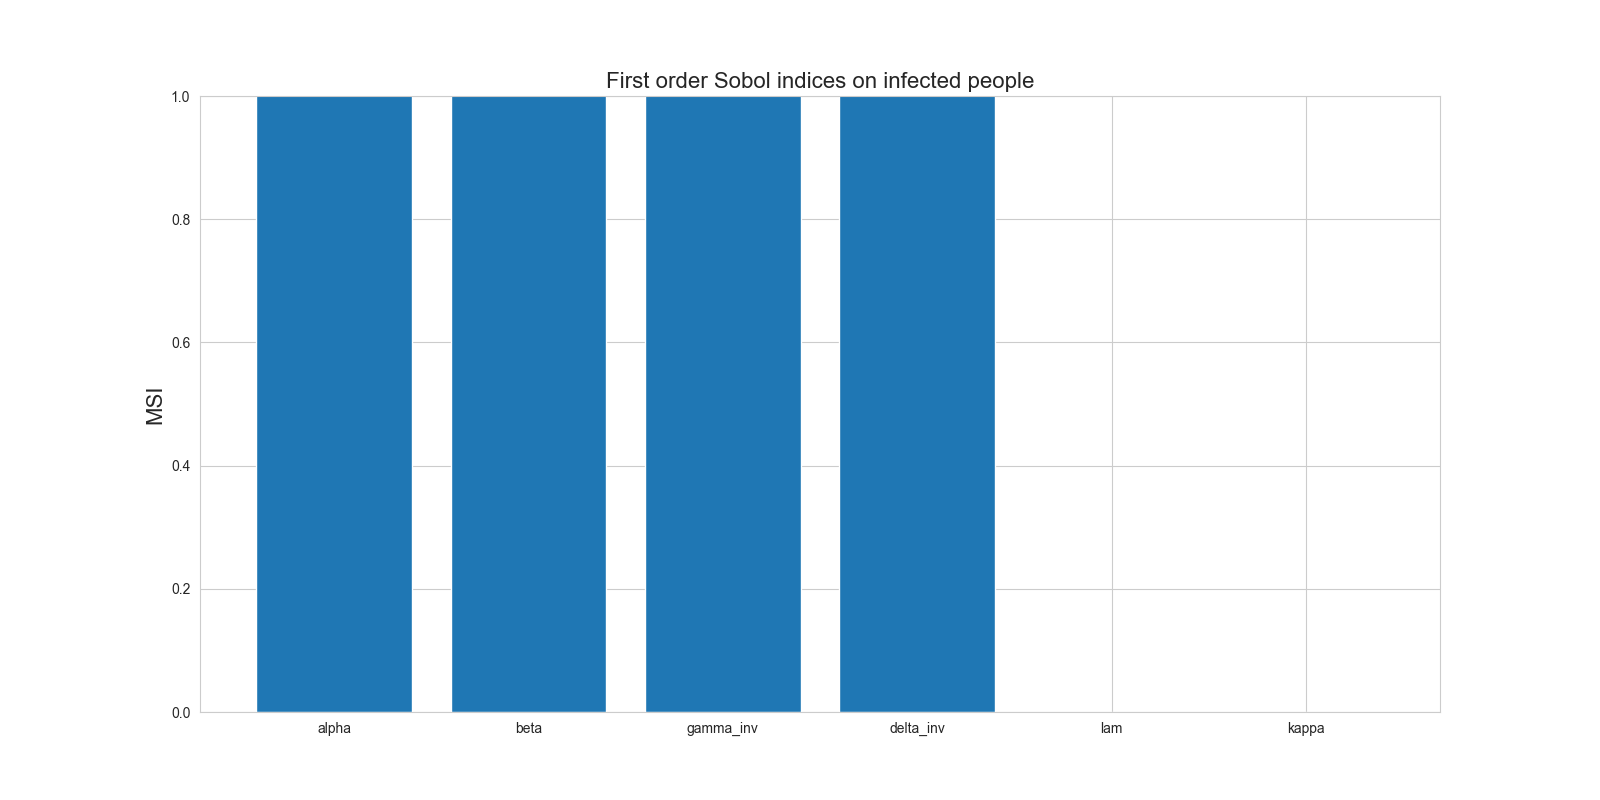

In [31]:
var_names=["alpha",
           "beta",
           "gamma_inv",
           "delta_inv",
           "lam",
           "kappa"]

plt.clf()
plt.bar(var_names, first_s_int)
# Add labels and title
plt.ylim(0,1)
plt.ylabel('MSI',fontsize=16)
plt.title('First order Sobol indices on infected people',fontsize=16)

# Show the plot
plt.show()

In [19]:
# Using the mean

first_order_sobol_mean=np.array(np.zeros(6))
total_sobol_mean=np.array(np.zeros(6))

#Starting from day 5 as they did
for i in range(6):
    first_order_sobol_mean[i]=np.mean(SA.first_order_indices[i, timespan])
    total_sobol_mean[i]=np.mean(SA.total_order_indices[i, timespan])
    
print(total_sobol_mean)
print(first_order_sobol_mean)

[0.69669357 0.10519103 0.03617276 0.59253932 0.02879857 0.02879857]
[ 0.35612572  0.02122914  0.00822779  0.27765575 -0.00679105 -0.00679105]
